In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from io import StringIO
from lxml import etree
import xml.etree.ElementTree as ET
import os
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize

In [ ]:
def format_xml(path):
    txt = Path(path).read_text()
    xml_data = StringIO(txt)

    df = pd.read_xml(xml_data, 
                    xpath="//dc:title", 
                    namespaces={"dc": "http://purl.org/dc/elements/1.1/", "dcterms":"http://purl.org/dc/terms/", 
                                                            "xsi": "http://www.w3.org/2001/XMLSchema-instance"},
                    parser="lxml")
    df = df.convert_dtypes(convert_string=True)

    txt = Path(path).read_text()
    xml_data = StringIO(txt)

    df2 = pd.read_xml(xml_data, 
                    xpath="//dc:description", 
                    namespaces={"dc": "http://purl.org/dc/elements/1.1/", "dcterms":"http://purl.org/dc/terms/", 
                                                            "xsi": "http://www.w3.org/2001/XMLSchema-instance"},
                    parser="lxml")
    
    df2 = df2.convert_dtypes(convert_string=True)
    df = df.merge(df2, on='lang', how='left')

    df.set_index('lang', inplace=True)
    data = {'title_en': [df['title']['en']], 'title_es': [df['title']['es']], 'description_en': [df['description']['en']], 'description_es': [df['description']['es']]}
    df = pd.DataFrame.from_dict(data)

    df['Source'] = 'MedlinePlus'
    df['File'] = f'{path}'

    return df

In [ ]:
def create_dataframes(dir):
    directory = dir

    dataframes = []
    counter = 0

    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            try:
                df = format_xml(f)
                dataframes.append(df)
            except (UnicodeDecodeError, ValueError, KeyError):
                print(f)
                counter += 1

    print(counter)

    final = pd.concat(dataframes, ignore_index=True)
    return final

In [ ]:
# final.to_csv('Pubmed.csv', index=False)
final = create_dataframes('Pubmed')

In [ ]:
final['NumWordsEn'] = final.apply(lambda x: len((str(x['description_en'])).split()), axis=1)
final['NumWordsEs'] = final.apply(lambda x: len((str(x['description_es'])).split()), axis=1)

In [ ]:
print(final)

In [ ]:
final['NumWordsEn'].hist()

# add labels and title
plt.xlabel('Num')
plt.ylabel('Frequency')
plt.title('Distribution of Words En Pubmed')

In [ ]:
final['NumWordsEs'].hist()

# add labels and title
plt.xlabel('Num')
plt.ylabel('Frequency')
plt.title('Distribution of Words Es Pubmed')

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
from io import StringIO
from lxml import etree
import xml.etree.ElementTree as ET
import os
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize

__author__ = '{author}'
__copyright__ = 'Copyright {year}, {project_name}'
__credits__ = ['{credit_list}']
__license__ = '{license}'
__version__ = '{mayor}.{minor}.{rel}'
__maintainer__ = '{maintainer}'
__email__ = '{contact_email}'
__status__ = '{dev_status}'

def format_xml(path, source):
    # Given string path, read one xml file
    # Source to create source column - Equivalent to dir
    txt = Path(path).read_text()
    xml_data = StringIO(txt)

    # Take advantage of xml schemas to extract the fields we want - located in xpath
    # Each df produced by this method returns en title and es title as separate rows
    df = pd.read_xml(xml_data, 
                    xpath="//dc:title", 
                    namespaces={"dc": "http://purl.org/dc/elements/1.1/", "dcterms":"http://purl.org/dc/terms/", 
                                                            "xsi": "http://www.w3.org/2001/XMLSchema-instance"},
                    parser="lxml")
    df = df.convert_dtypes(convert_string=True)

    # Must reopen file and rextract to get the other fields
    txt = Path(path).read_text()
    xml_data = StringIO(txt)

    df2 = pd.read_xml(xml_data, 
                    xpath="//dc:description", 
                    namespaces={"dc": "http://purl.org/dc/elements/1.1/", "dcterms":"http://purl.org/dc/terms/", 
                                                            "xsi": "http://www.w3.org/2001/XMLSchema-instance"},
                    parser="lxml")
    
    # Dataframe formatting to make sure they are the same types for joining
    df2 = df2.convert_dtypes(convert_string=True)
    df = df.merge(df2, on='lang', how='left')

    # Dataframe operations to reshape the data into single rows
    df.set_index('lang', inplace=True)
    data = {'title_en': [df['title']['en']], 'title_es': [df['title']['es']], 'description_en': [df['description']['en']], 'description_es': [df['description']['es']]}
    df = pd.DataFrame.from_dict(data)

    df['Source'] = f'{source}'
    df['File'] = f'{path}'

    return df

def create_dataframes(dir):
    directory = dir
    dataframes = []
    counter = 0

    # Main loop that iterates through each file in the directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        # if it is a file, format using above function and store dataframe in a list
        if os.path.isfile(f):
            try:
                df = format_xml(f, dir)
                dataframes.append(df)
            except (UnicodeDecodeError, ValueError, KeyError):
                print(f)
                counter += 1

    print(counter)

    # connect all dataframes in list together - faster than joining dataframes at every step
    final = pd.concat(dataframes, ignore_index=True)

    return final

def count_words(df):
    # Counting words using split - slightly inflated by punctuation but good enough
    df['NumWordsEn'] = df.apply(lambda x: len((str(x['description_en'])).split()), axis=1)
    df['NumWordsEs'] = df.apply(lambda x: len((str(x['description_es'])).split()), axis=1)

    return df

def count_sentences(df):
    # Counting sentences using nltk setn_tokenize, which uses punkt
    df['NumSentencesEn'] = df.apply(lambda x: len(sent_tokenize(x['description_en'], language='english')) if isinstance(x['description_en'], str) else 0, axis=1)
    df['NumSentencesEs'] = df.apply(lambda x: len(sent_tokenize(x['description_es'], language='spanish')) if isinstance(x['description_es'], str) else 0, axis=1)

    return df

def graph_wordcount_en(df, source):
    df['NumWordsEn'].hist()

    # add labels and title
    plt.xlabel('Num')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Words En {source}')
    plt.show()

def graph_wordcount_es(df, source):
    df['NumWordsEs'].hist()

    # add labels and title
    plt.xlabel('Num')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Words Es {source}')
    plt.show()

def graph_sentcount_en(df, source):
    df['NumSentencesEn'].hist()

    # add labels and title
    plt.xlabel('Num')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Sentences En {source}')
    plt.show()

def graph_sentcount_es(df, source):
    df['NumSentencesEs'].hist()

    # add labels and title
    plt.xlabel('Num')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Sentences Es{source}')
    plt.show()

def main():
    dir = 'Pubmed'
    df = create_dataframes('Pubmed')

    df = count_words(df)
    df = count_sentences(df)

    graph_wordcount_en(df, dir)
    graph_wordcount_es(df, dir)

Pubmed\100061.xml
Pubmed\100076.xml
Pubmed\1001573.xml
Pubmed\1001577.xml
Pubmed\1001581.xml
Pubmed\1001859.xml
Pubmed\10027181.xml
Pubmed\10027185.xml
Pubmed\10027189.xml
Pubmed\1004206.xml
Pubmed\10047912.xml
Pubmed\10047919.xml
Pubmed\10047923.xml
Pubmed\10050615.xml
Pubmed\1005292.xml
Pubmed\1005790.xml
Pubmed\1005794.xml
Pubmed\1005798.xml
Pubmed\1005802.xml
Pubmed\1005806.xml
Pubmed\1005810.xml
Pubmed\1005821.xml
Pubmed\1005825.xml
Pubmed\1005829.xml
Pubmed\1005836.xml
Pubmed\1005863.xml
Pubmed\1005870.xml
Pubmed\1005874.xml
Pubmed\1005878.xml
Pubmed\1005897.xml
Pubmed\1005962.xml
Pubmed\1006501.xml
Pubmed\10065437.xml
Pubmed\10065441.xml
Pubmed\10068720.xml
Pubmed\10068739.xml
Pubmed\10068754.xml
Pubmed\10069114.xml
Pubmed\10069118.xml
Pubmed\10069122.xml
Pubmed\10073094.xml
Pubmed\10074619.xml
Pubmed\10074638.xml
Pubmed\10076468.xml
Pubmed\10079546.xml
Pubmed\10079553.xml
Pubmed\10079561.xml
Pubmed\10079690.xml
Pubmed\10079694.xml
Pubmed\10081166.xml
Pubmed\10081174.xml
Pubmed\

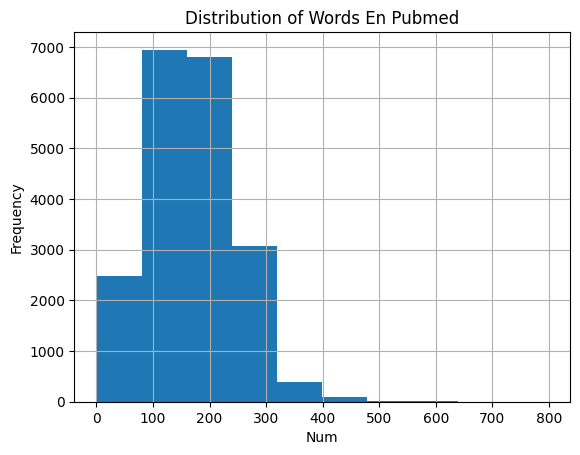

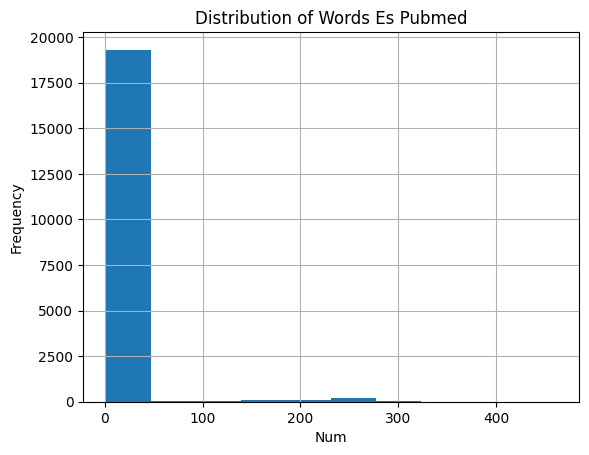

In [12]:
dir = 'Pubmed'
df = create_dataframes('Pubmed')

df = count_words(df)
df = count_sentences(df)

graph_wordcount_en(df, dir)
graph_wordcount_es(df, dir)